In [ ]:
import re


def clean_title(title):
    # Extract the authority and the rest of the title
    match = re.match(
        r"^(?:Rozporządzenie|Obwieszczenie)\s+(.*?)\s+z\s+dnia.*?(?:w sprawie|zmieniające)",
        title,
        re.IGNORECASE,
    )
    authority = match.group(1) if match else ""

    # Remove the document type, date, and "w sprawie" phrases
    title = re.sub(r"^.*?(?:z dnia \d+\s+\w+\s+\d{4}\s*r\.\s*)", "", title)
    title = re.sub(
        r"(?:zmieniające\s+rozporządzenie\s+)?w\s+sprawie\s+", "dot. ", title
    )
    title = title.replace(
        "Rzeczypospolitej Polskiej ogłoszenia jednolitego tekstu ustawy", ""
    )

    # Combine authority with cleaned title
    cleaned_title = f"{authority} {title}".strip()

    # Remove code patterns like (PLH120079)
    cleaned_title = re.sub(r"\(\w+\d+\)", "", cleaned_title)

    # Remove extra whitespace
    cleaned_title = re.sub(r"\s+", " ", cleaned_title).strip()

    # Remove specific patterns - now excluding 'Ministra' and 'Marszałka'
    patterns_to_remove = [
        r"Prezesa Rady Ministrów",
        r"Rady Ministrów",
        r"ogłoszenia jednolitego tekstu",
        r"zmieniające rozporządzenie",
        r"ustawy -"
    ]
    for pattern in patterns_to_remove:
        cleaned_title = re.sub(pattern, "", cleaned_title)

    # Final cleanup
    cleaned_title = re.sub(r"\s+", " ", cleaned_title).strip()

    return cleaned_title

In [ ]:
import pandas as pd
from collections import defaultdict
import re
from tqdm import tqdm

def find_common_substrings(df, min_length=20, min_occurrences=10):
    substring_counts = defaultdict(int)
    # Clean and prepare titles
    titles = df['title'].str.strip().tolist()
    total_titles = len(titles)
    
    # First, find all "Rozporządzenie/Obwieszczenie X z dnia" patterns
    skip_pattern = re.compile(r'^(?:Rozporządzenie|Obwieszczenie)\s+.*?\s+z\s+dnia')
    
    print(f"Analyzing substrings in {total_titles} documents...")
    for title in tqdm(titles):
        # Skip administrative part of the title
        skip_match = skip_pattern.match(title)
        if skip_match:
            start_idx = skip_match.end()
            title = title[start_idx:]
        
        # Get all possible substrings of meaningful length
        words = title.split()
        for i in range(len(words)):
            for j in range(i + 1, len(words) + 1):
                substring = ' '.join(words[i:j])
                if len(substring) >= min_length:
                    substring_counts[substring] += 1

    # Filter by minimum occurrences and create DataFrame
    common_substrings = [
        (substr, count, len(substr), round(count/total_titles * 100, 2))
        for substr, count in substring_counts.items()
        if count >= min_occurrences
    ]
    
    # Create DataFrame and sort primarily by occurrences
    result_df = pd.DataFrame(
        common_substrings,
        columns=['substring', 'occurrences', 'length', 'percentage']
    )
    
    # Sort by occurrences (descending) and then by length (descending)
    result_df = result_df.sort_values(
        by=['occurrences', 'length'],
        ascending=[False, False]
    ).reset_index(drop=True)
    
    return result_df, total_titles

def analyze_titles(csv_path, min_length=20, min_occurrences=5):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Find common substrings
    common_substrings_df, total_docs = find_common_substrings(
        df,
        min_length=min_length,
        min_occurrences=min_occurrences
    )
    
    pd.set_option('display.max_colwidth', None)
    print(f"\nAnalyzed {total_docs} documents")
    print(f"Found {len(common_substrings_df)} common substrings")
    print("\nMost common substrings (sorted by number of occurrences):")
    
    # Format the output for better readability
    for idx, row in common_substrings_df.head(20).iterrows():
        print("\n" + "="*80)
        print(f"#{idx + 1}: Occurs in {row['occurrences']} documents ({row['percentage']}%)")
        print(f"Length: {row['length']} characters")
        print(f"Substring: {row['substring']}")
    
    # Summary statistics
    print("\n" + "="*80)
    print("\nOccurrence Statistics:")
    print(f"Most frequent: {common_substrings_df['occurrences'].max()} occurrences")
    print(f"Median occurrences: {common_substrings_df['occurrences'].median()}")
    print(f"Mean occurrences: {common_substrings_df['occurrences'].mean():.2f}")
    
    return common_substrings_df

# Usage:
# results_df = analyze_titles('Acts.csv', min_length=20, min_occurrences=5)

In [ ]:
analyze_titles('acts_cleaned.csv')

In [ ]:
from __future__ import annotations
import os
from pathlib import Path
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
import vertexai

credentials_path = Path().cwd().parent / "sejm-stats-439117-39efc9d2f8b8.json"
print(credentials_path)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(credentials_path)


vertexai.init(project="sejm-stats-439117")



def embed_text(texts: list) -> list[list[float]]:
    dimensionality = None
    # dimensionality = 768
    task = "RETRIEVAL_DOCUMENT"


    model = TextEmbeddingModel.from_pretrained("textembedding-gecko-multilingual@latest")


    inputs = [TextEmbeddingInput(text, task) for text in texts]


    kwargs = dict(output_dimensionality=dimensionality) if dimensionality else {}


    embeddings = model.get_embeddings(inputs, **kwargs)

    return [embedding.values for embedding in embeddings]

In [ ]:
from pydantic import BaseModel
import requests
import pdfplumber
import re
import tempfile
from loguru import logger
class DocumentChunk(BaseModel):
    start_page: int
    end_page: int
    content: str
    chapter_title: str| None = None  # If you can extract section headings
    word_count: int = 0
    
def clean_text(text: str) -> str:
    """Enhanced text cleaning for Polish legal documents that preserves structure."""
    logger.debug("Cleaning text of length {}", len(text))
    
    # Replace multiple spaces with single space, but preserve newlines
    text = re.sub(r' +', ' ', text)
    
    # Clean up newlines but preserve paragraph structure
    text = re.sub(r'\n\s*\n+', '\n\n', text)
    
    # Format section headers
    text = re.sub(r'(^|\n)§\s*(\d+)', r'\n\n### § \2', text)
    text = re.sub(r'(^|\n)Art\.\s*(\d+)', r'\n\n### Art. \2', text)
    
    # Format table headers
    text = re.sub(r'(^|\n)Tabela\s+(\d+)', r'\n\n## Tabela \2', text)
    
    # Format attachments
    text = re.sub(r'(^|\n)Załącznik\s+[Nn]r\s*(\d+)', r'\n\n## Załącznik nr \2', text)
    
    # Clean up common artifacts but preserve structure
    text = re.sub(r'©.*?\n', '', text)
    text = re.sub(r'Dziennik\s+Ustaw.*?(?=\n)', '', text)
    text = re.sub(r'Poz\.\s*\d+.*?(?=\n)', '', text)
    
    return text.strip()

In [340]:
import base64
from dataclasses import dataclass
from typing import List, NamedTuple, Optional
import vertexai
from vertexai.generative_models import GenerativeModel
from vertexai.preview.prompts import Prompt
import pdfplumber
import requests
import tempfile
import re
import csv
from time import sleep
from loguru import logger
from vertexai.generative_models import GenerativeModel, Part, SafetySetting
import re


@dataclass
class Section:
    title: str
    content: str
    start_char: int
    end_char: int



In [349]:
def find_document_start(text: str) -> Optional[int]:
    """Find the starting position of actual document content."""
    starting_patterns = [
        r"ROZPORZĄDZENIE\s+MINISTR",  # Handle cases like "MINISTRA", "MINISTRÓW"
        r"USTAWA\s+z\s+dnia",
    ]
    for pattern in starting_patterns:
        pattern = r"\s*".join(pattern.split())  # Make whitespace flexible
        if match := re.search(pattern, text, re.MULTILINE):
            logger.info(
                f"Found document start with pattern '{pattern}' at position {match.start()}"
            )
            return match.start()
    logger.warning("No document start pattern found")
    return None


def get_hierarchical_sections(text: str, start_pos: int) -> List[dict]:
    """Get all sections with their hierarchical level and position."""
    # Negative lookahead to exclude citations/references
    exclusion_pattern = r"(?!\s*\(zawierający|\s*\(uchylony|\s*\(art\.)"

    patterns = {
        "tytul": rf"TYTUŁ\s+[IVXLC]+{exclusion_pattern}\.?\s*([^\n]+)",
        "dzial": rf"DZIAŁ\s+[IVXLC]+{exclusion_pattern}\.?\s*([^\n]+)",
        "rozdzial": rf"Rozdział\s+(?:\d+|[IVXLC]+){exclusion_pattern}\.?\s*([^\n]+)",
    }

    sections = []
    for level, pattern in patterns.items():
        matches = list(re.finditer(pattern, text))
        for match in matches:
            # Additional verification that it's not a citation
            title = match.group(1).strip()
            if any(x in title for x in ["(zawierający", "(uchylony", "(art."]):
                logger.debug(f"Skipping citation/reference: {title}")
                continue

            section = {
                "level": level,
                "title": title,
                "start": start_pos + match.start(),
                "end": start_pos + match.end(),
                "match_text": match.group(0),
            }
            sections.append(section)
            logger.debug(
                f"Found {level}: '{section['title']}' at position {section['start']}"
            )

    sorted_sections = sorted(sections, key=lambda x: x["start"])
    logger.info(f"Found total {len(sorted_sections)} sections")
    return sorted_sections


def create_section_title(sections: List[dict], current_idx: int) -> str:
    """Create hierarchical title based on current and parent sections."""
    current = sections[current_idx]

    # Find all sections at the same level up to the current one
    same_level_sections = []
    parent_title = None
    parent_dzial = None

    for prev in reversed(sections[: current_idx + 1]):
        # Collect sections of the same level
        if prev["level"] == current["level"]:
            same_level_sections.insert(0, prev["title"])

        # Find closest parent title for dzial and rozdzial
        if prev["level"] == "tytul" and current["level"] in ["dzial", "rozdzial"]:
            parent_title = prev["title"]
            break

    # For rozdzial, find parent dzial after finding parent title
    if current["level"] == "rozdzial" and parent_title:
        for prev in reversed(sections[:current_idx]):
            if prev["level"] == "dzial":
                parent_dzial = prev["title"]
                break

    # Build the hierarchical title
    parts = []
    if parent_title:
        parts.append(f"  {parent_title}")
    if parent_dzial and current["level"] == "rozdzial":
        parts.append(f"Dział: {parent_dzial}")

    # Add current level sections
    current_level = (
        f"{current['level'].capitalize()}: {' | '.join(same_level_sections)}"
    )
    parts.append(current_level)

    return " -> ".join(parts)


def process_section_content(
    sections: List[dict], text: str, start_pos: int
) -> List[Section]:
    """Process sections and their content with minimum section size of 5000 characters."""
    result = []
    text_length = len(text)
    MIN_SECTION_SIZE = 5000

    logger.info(f"Processing {len(sections)} sections")

    i = 0
    while i < len(sections):
        current = sections[i]
        combined_sections = [current]
        combined_content_start = current["start"] - start_pos

        # Determine initial section end
        if i < len(sections) - 1:
            content_end = sections[i + 1]["start"] - start_pos
        else:
            content_end = text_length

        content = text[combined_content_start:content_end]
        current_size = len(content)

        # If content is smaller than minimum size and not the last section,
        # try to combine with next sections
        while current_size < MIN_SECTION_SIZE and i < len(sections) - 1:
            i += 1
            next_section = sections[i]
            combined_sections.append(next_section)

            # Determine next section end
            if i < len(sections) - 1:
                next_end = sections[i + 1]["start"] - start_pos
            else:
                next_end = text_length

            # Update content and size
            content = text[combined_content_start:next_end]
            current_size = len(content)

        # Create combined title based on section levels
        def get_base_hierarchy(section):
            """Get the base hierarchy level (tytuł/dział) for a section."""
            if section["level"] == "tytul":
                return "tytul"
            elif section["level"] == "dzial":
                return "dzial"
            else:  # rozdzial
                return "rozdzial"

        # Group sections by their base hierarchy
        current_group = []
        grouped_titles = []
        base_level = get_base_hierarchy(combined_sections[0])

        for section in combined_sections:
            section_level = get_base_hierarchy(section)
            if section_level != base_level:
                if current_group:
                    title_parts = [s["title"] for s in current_group]
                    grouped_titles.append(" | ".join(title_parts))
                    current_group = []
                base_level = section_level
            current_group.append(section)

        # Add the last group
        if current_group:
            title_parts = [s["title"] for s in current_group]
            grouped_titles.append(" | ".join(title_parts))

        # Create the final combined title
        if len(grouped_titles) > 1:
            combined_title = " -> ".join(grouped_titles)
        else:
            combined_title = grouped_titles[0]

        # Handle large sections
        if current_size > 15000:
            logger.info(
                f"Splitting large section '{combined_title}' of {current_size} chars"
            )
            chunks = create_paginated_sections(
                combined_title, content, combined_sections[0]["start"]
            )
            result.extend(chunks)
        else:
            result.append(
                Section(
                    title=combined_title,
                    content=content,
                    start_char=combined_sections[0]["start"],
                    end_char=combined_sections[0]["start"] + len(content),
                )
            )
            logger.debug(f"Added section '{combined_title}' with {current_size} chars")

        i += 1

    return result


def split_into_sections(text: str) -> List[Section]:
    """Split document into hierarchical sections."""
    logger.info(f"Processing document of length {len(text)}")

    if not (start_pos := find_document_start(text)):
        logger.warning("No document start found, returning whole text as one section")
        return [
            Section(title="Dokument", content=text, start_char=0, end_char=len(text))
        ]

    # Get actual document content
    text = text[start_pos:]
    logger.info(f"Document content length after start: {len(text)}")

    # Get all sections
    sections = get_hierarchical_sections(text, start_pos)

    if not sections:
        logger.warning("No sections found, paginating whole document")
        return create_paginated_sections("Dokument", text, start_pos)

    # Process sections and their content
    result = process_section_content(sections, text, start_pos)
    logger.info(f"Created {len(result)} final sections")
    #  get only sections longer then 250 characters

    return result


def create_paginated_sections(
    title: str, content: str, start_pos: int
) -> List[Section]:
    """Create paginated sections for large content."""
    chunk_size = 15000
    total_pages = (len(content) + chunk_size - 1) // chunk_size

    result = []
    for i in range(0, len(content), chunk_size):
        chunk = content[i : i + chunk_size]
        page_num = i // chunk_size + 1

        chunk_title = (
            f"{title} (Część {page_num}/{total_pages})" if total_pages > 1 else title
        )

        result.append(
            Section(
                title=chunk_title,
                content=chunk,
                start_char=start_pos + i,
                end_char=start_pos + i + len(chunk),
            )
        )

    return result

In [ ]:
SYSTEM_MESSAGE = """
You are a legal expert specializing in creating concise summaries of legal documents for vector models. Your responses must always be in Polish language. Follow these rules:

1. IGNORE completely all information contained in the legal act's title and metadata
3. AVOID:
   - procedural and formal terminology
   - repeating information from metadata
   - references to document structure (chapters, articles)
   - information about authors and type of legal act
4. USE:
   - simple, understandable language
   - concrete examples of practical application of provisions
   - concise, factual phrasing

Response format:
- Maximum 5 sentences
- Continuous text without bullet points
- Exclusively in Polish language
"""



def generate_summary(prompt: Prompt) -> str:
    responses = prompt.generate_content(
        contents=prompt.assemble_contents(**prompt.variables[0]),
        stream=True,
        safety_settings=[
            SafetySetting(category=cat, threshold=SafetySetting.HarmBlockThreshold.OFF)
            for cat in [
                SafetySetting.HarmCategory.HARM_CATEGORY_HATE_SPEECH,
                SafetySetting.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
                SafetySetting.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
                SafetySetting.HarmCategory.HARM_CATEGORY_HARASSMENT,
            ]
        ],
    )
    return " ".join("".join(response.text for response in responses).split())


def process_legal_documents(elis: List[str], output_csv: str):
    vertexai.init(project="sejm-stats-439117", location="us-central1")

    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(
            [
                "ELI",
                "title",
                "keywords",
                "ChapterTitle",
                "summary",
                "start_char",
                "end_char",
            ]
        )

        for eli in elis:
            try:
                # Fetch metadata
                metadata = requests.get(
                    f"https://api.sejm.gov.pl/eli/acts/{eli}/"
                ).json()
                doc_metadata = {
                    "doc_title": metadata.get("title", ""),
                    "keywords": metadata.get("keywords", []),
                    "section_title": "",
                }

                # Download PDF
                response = requests.get(
                    f"https://api.sejm.gov.pl/eli/acts/{eli}/text.pdf"
                )
                response.raise_for_status()

                with tempfile.NamedTemporaryFile(
                    suffix=".pdf", delete=False
                ) as temp_pdf:
                    temp_pdf.write(response.content)

                    with pdfplumber.open(temp_pdf.name) as pdf:
                        full_text = ""
                        for page in pdf.pages:
                            full_text += page.extract_text() or ""

                        chapters = split_into_sections(full_text)
                        for chapter in chapters:
                            doc_metadata["section_title"] = chapter.title
                            # prompt = create_prompt(chapter.content, doc_metadata)
                            # summary = generate_summary(prompt)
                            writer.writerow(
                                [
                                    eli,
                                    doc_metadata["doc_title"],
                                    ",".join(doc_metadata["keywords"]),
                                    chapter.title,
                                    # summary,
                                    chapter.content,
                                    chapter.start_char,
                                    chapter.end_char,
                                ]
                            )

                            # sleep(8)  # Rate limiting

                logger.success(f"Completed processing: {eli}")

            except Exception as e:
                logger.error(f"Error processing {eli}: {str(e)}")
                continue


if __name__ == "__main__":
    elis_to_process = [
        "DU/2024/1587",  # RANDOMOWE ROZPORZĄDZENIE
        "DU/2023/2151",  # ALKOHOL
        "DU/2024/1061",  # KODEKS CYWILNY
        "DU/2024/17",  # KODEKS KAARNY
    ]
    process_legal_documents(elis_to_process, "legal_acts_sections.csv")

2024-11-01 17:08:50.943 | INFO     | __main__:split_into_sections:203 - Processing document of length 14046
2024-11-01 17:08:50.944 | INFO     | __main__:find_document_start:10 - Found document start with pattern 'ROZPORZĄDZENIE\s+MINISTR' at position 3592
2024-11-01 17:08:50.945 | INFO     | __main__:split_into_sections:213 - Document content length after start: 10454
2024-11-01 17:08:50.946 | INFO     | __main__:get_hierarchical_sections:52 - Found total 0 sections
2024-11-01 17:08:50.946 | WARNING  | __main__:split_into_sections:219 - No sections found, paginating whole document
2024-11-01 17:08:50.947 | SUCCESS  | __main__:process_legal_documents:135 - Completed processing: DU/2024/1587
2024-11-01 17:08:56.649 | INFO     | __main__:split_into_sections:203 - Processing document of length 127194
2024-11-01 17:08:56.650 | INFO     | __main__:find_document_start:10 - Found document start with pattern 'USTAWA\s+z\s+dnia' at position 2975
2024-11-01 17:08:56.650 | INFO     | __main__:spl

In [421]:
summaries = pd.read_csv("legal_acts_sections.csv")
summaries.head()
# start_char,end_char give me avg of end_char - start_char
avg = (summaries["end_char"] - summaries["start_char"]).mean()
avg

8578.594339622641

In [426]:
response = requests.get(
    f"https://api.sejm.gov.pl/eli/acts/DU/2024/1061/text.pdf"
)
response.raise_for_status()

with tempfile.NamedTemporaryFile(
    suffix=".pdf", delete=False
) as temp_pdf:
    temp_pdf.write(response.content)

    with pdfplumber.open(temp_pdf.name) as pdf:
        full_text = ""
        for page in pdf.pages:
            full_text += page.extract_text() or ""

In [422]:
def prepare_row(row: pd.Series) -> str:
    eli = row["ELI"]
    keywords = row["keywords"]
    title = row["title"].replace("w sprawie ogłoszenia jednolitego tekstu", "")
    chapter_title = row["ChapterTitle"]
    summary = row["summary"]
    # return f"Tytuł: {clean_title(title)}, {keywords}\n\nRozdział: {chapter_title}\n\nPodsumowanie: {summary}\n\n{eli}"
    return f"Tytuł: {clean_title(title)} \nFragment: {chapter_title}\nPodsumowanie: {summary}\n\n{eli}"

texts = summaries.apply(prepare_row, axis=1).tolist()

texts_with_summaries = texts
texts[66]

'Tytuł: Kodeks cywilny \nFragment: Zachowek\nPodsumowanie: TYTUŁ IV\nZachowek\nArt. 991. § 1. Zstępnym, małżonkowi oraz rodzicom spadkodawcy, którzy byliby powołani do spadku z ustawy, należą się,\njeżeli uprawniony jest trwale niezdolny do pracy albo jeżeli zstępny uprawniony jest małoletni – dwie trzecie wartości\nudziału spadkowego, który by mu przypadał przy dziedziczeniu ustawowym, w innych zaś wypadkach – połowa wartości\ntego udziału (zachowek).\n§ 2. Jeżeli uprawniony nie otrzymał należnego mu zachowku bądź w postaci uczynionej przez spadkodawcę daro-\nwizny, bądź w postaci powołania do spadku, bądź w postaci zapisu, bądź w postaci świadczenia od fundacji rodzinnej lub\nmienia w związku z rozwiązaniem fundacji rodzinnej, przysługuje mu przeciwko spadkobiercy roszczenie o zapłatę sumy\npieniężnej potrzebnej do pokrycia zachowku albo do jego uzupełnienia.\nArt. 992. Przy ustalaniu udziału spadkowego stanowiącego podstawę do obliczania zachowku uwzględnia się także\nspadkobierców 

In [423]:
def split_texts(texts, max_chars=5000):
    chunks = []
    current_chunk = []
    current_token_count = 0

    for text in texts:
        token_count = len(text.split())  # Assuming each word is a token
        if current_token_count + token_count > max_chars:
            chunks.append(current_chunk)
            current_chunk = []
            current_token_count = 0
        current_chunk.append(text)
        current_token_count += token_count

    if current_chunk:
        chunks.append(current_chunk)

    return chunks

def embed_texts_in_chunks(texts, max_tokens=5000):
    chunks = split_texts(texts, max_tokens)
    all_embeddings = []

    for chunk in chunks:
        print(f"Processing chunk with {len(chunk)} texts...")
        chunk_embeddings = embed_text(chunk)
        all_embeddings.extend(chunk_embeddings)

    return all_embeddings
embeddings = embed_texts_in_chunks(texts_with_summaries)


In [429]:

phrase_embeddings = embed_text(["czesc nauczycieka na sprawdzianie kaze nam chowac telefony do specjalnego pudelka to jest legalne? "])
len(phrase_embeddings[0])

768

In [428]:
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint
# only title - chapterTitle
texts = pd.read_csv("legal_acts_sections.csv")
similarities_with_sum = cosine_similarity(phrase_embeddings, embeddings)
# Get the indices of the top 5 most similar documents
top_5_indices = similarities_with_sum[0].argsort()[-8:][::-1]
# Print the top 5 most similar documents and their similarity scores
for index in top_5_indices:
    pprint(texts["title"][index][-70:])
    pprint(texts["ChapterTitle"][index])
    # pprint(texts["summary"][index])
    print(similarities_with_sum[0][index],"\n")

'kstu ustawy o wychowaniu w trzeźwości i przeciwdziałaniu alkoholizmowi'
'Postępowanie w stosunku do osób nadużywających alkoholu (Część 4/4)'
0.6902871682219609 

'kstu ustawy o wychowaniu w trzeźwości i przeciwdziałaniu alkoholizmowi'
'Postępowanie w stosunku do osób nadużywających alkoholu (Część 3/4)'
0.6854200677002444 

'024 r. w sprawie ogłoszenia jednolitego tekstu ustawy - Kodeks cywilny'
('Odpowiedzialność, prawo zastawu i przedawnienie roszczeń utrzymujących '
 'hotele i podobne zakłady | Umowa składu')
0.6850832167714773 

'024 r. w sprawie ogłoszenia jednolitego tekstu ustawy - Kodeks cywilny'
'1 | Wykonanie zobowiązań i skutki ich niewykonania -> Wykonanie zobowiązań'
0.6846343060217709 

'024 r. w sprawie ogłoszenia jednolitego tekstu ustawy - Kodeks cywilny'
('Ugoda | Przyrzeczenie publiczne | Przekaz i papiery wartościowe -> Przekaz | '
 'Papiery wartościowe')
0.6833957789467872 

'024 r. w sprawie ogłoszenia jednolitego tekstu ustawy - Kodeks cywilny'
('Umowa komisu |

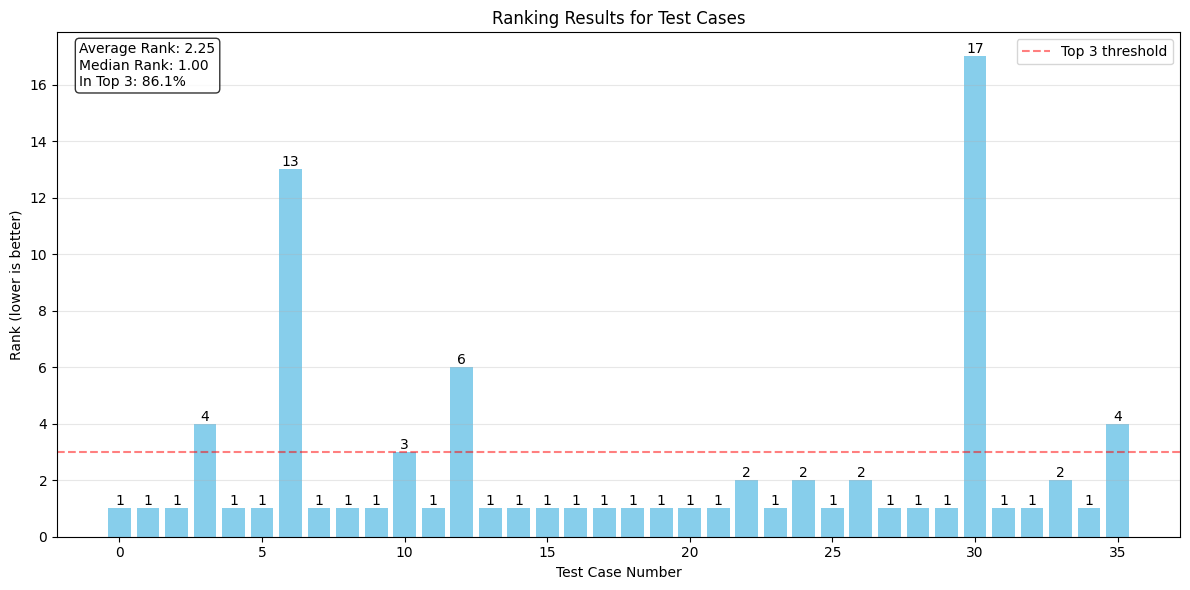


Detailed Results:
                                                                                                            prompt  rank  similarity
0                                                                        Spożywanie alkoholu w miejscu nielegalnym     1    0.788186
1                                                                      Zdolność osoby 16-letniej do zawarcia umowy     1    0.786463
2                                                                             Dziedziczenie majątku bez testamentu     1    0.782080
3                                                                           Zabezpieczenie pożyczki na samochodzie     4    0.729984
4                                                                                      Prawa osoby niepełnoletniej     1    0.762873
5                                                                      Unieważnienie testamentu pod wpływem groźby     1    0.769258
6                                                 

In [424]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def evaluate_test_cases(test_df, legal_df, test_embeddings, legal_embeddings):
    # Calculate similarities for all test cases at once
    similarities = cosine_similarity(test_embeddings, legal_embeddings)
    
    results = []
    for i, row in test_df.iterrows():
        # Get sorted indices for this test case
        sorted_indices = similarities[i].argsort()[::-1]
        
        # Find correct position
        rank = -1
        for pos, idx in enumerate(sorted_indices, 1):
            if (legal_df['ELI'].iloc[idx] == row['ELI'] and 
                 (row['chapter'].lower() in legal_df['ChapterTitle'].iloc[idx].lower())):
                rank = pos
                break
                
        results.append({
            'prompt': row['prompt'],
            'rank': rank,
            'similarity': similarities[i][sorted_indices[0]]
        })
    
    return pd.DataFrame(results)

def plot_results(results_df):
    plt.figure(figsize=(12, 6))
    positions = results_df['rank'].values
    
    plt.bar(range(len(positions)), positions, color='skyblue')
    plt.axhline(y=3, color='r', linestyle='--', alpha=0.5, label='Top 3 threshold')
    
    plt.title('Ranking Results for Test Cases')
    plt.xlabel('Test Case Number')
    plt.ylabel('Rank (lower is better)')
    plt.grid(True, axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(positions):
        plt.text(i, v, str(v), ha='center', va='bottom')
    
    # Stats box
    stats = (f'Average Rank: {np.mean(positions):.2f}\n'
            f'Median Rank: {np.median(positions):.2f}\n'
            f'In Top 3: {(positions <= 3).mean() * 100:.1f}%')
    
    plt.text(0.02, 0.98, stats,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.tight_layout()
    return plt

def main():
    # Load data
    test_df = pd.read_csv('test.csv')
    legal_df = pd.read_csv('legal_acts_sections.csv')
    
    # Embed all texts at once
    test_embeddings = embed_text(test_df['prompt'].tolist())
    legal_embeddings = embeddings  # Assuming embeddings is already computed
    
    # Evaluate and plot
    results_df = evaluate_test_cases(test_df, legal_df, test_embeddings, legal_embeddings)
    plt = plot_results(results_df)
    plt.show()
    
    print("\nDetailed Results:")
    print(results_df.to_string())
    print("total score" , results_df['rank'].sum())
if __name__ == "__main__":
    main()